#[1주차] 심화과제 ( MNIST 예측 모델에 deep learning techniques 적용하기 )
( 학습 인자 n_epochs = 50, batch_size = 256 )

# CIFAR10 실습

제일 먼저 사용할 library들을 import합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms



## DataSet 및 activation 함수 변경

다음은 dataset을 준비합니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

### ( dataSets을 MNIST -> CIFAR10으로 변경 )

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

transform = transforms.ToTensor()
testset = torchvision.datasets.CIFAR10(
    root='./Testdata',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:05<00:00, 33372220.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 170498071/170498071 [00:03<00:00, 47103088.70it/s]


Extracting ./Testdata/cifar-10-python.tar.gz to ./Testdata


trainset 데이터가 잘 다운 됬는지 확인 하기 위해서 한개 표시

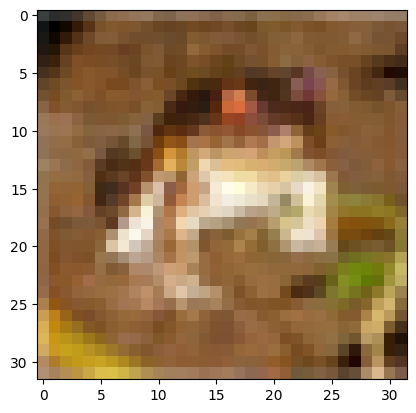

In [ ]:
from matplotlib import pyplot as plt


#1 번째 데이터 그림 확인
img, _ = trainset[0]

# 텐서를 numpy 배열로 변환하고 차원 순서 변경
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)

testset 데이터가 잘 다운 됬는지 확인 하기 위해서 한개 표시

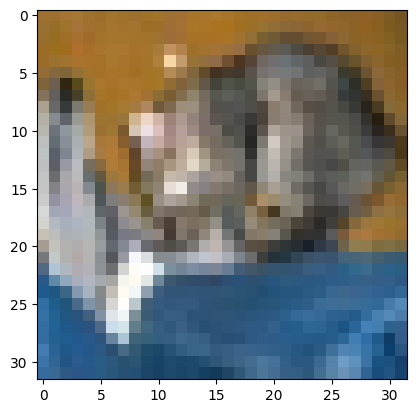

In [ ]:
#TestData 잘 가져왔는지 확인
from matplotlib import pyplot as plt

#1 번째 데이터 그림 확인
img, _ = testset[0]

# 텐서를 numpy 배열로 변환하고 차원 순서 변경
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)

### nn.ReLU -> nn.LeakyReLU 적용하기

nn.ReLU -> nn.LeakyReLU 으로 변경해서 나오도록 해서 3-layer MLP를 구현합니다.

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x



### 학습 인자 n_epoch = 50, batch_size = 256으로 지정

In [ ]:
#학습 인자 적용
n_epochs = 50
batch_size = 256

적용한 batch_size로 데이터 loader 생성

In [ ]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)


testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)


DataLoader로 batch가 잘 나누어 졌는지 확인을 위해서 첫 번째 batch를 출력한 모습입니다.

In [ ]:
print("trainloader")
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

print("testloader")
dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

trainloader
torch.Size([256, 3, 32, 32]) torch.Size([256])
testloader
torch.Size([256, 3, 32, 32]) torch.Size([256])


##CIFAR10의 입력 shape 확인

### CIFAR10은 MNIST와 다른 입력의 shape를 가지고 있기에 확인을 위한 코드

In [ ]:
#trainSet 데이터의 첫번째 shape 확인
print(trainset[0][0].shape)

torch.Size([3, 32, 32])


첫 번쨰 shape의 image인 (3, 32, 32) 를 입력받아 모델을 생성

In [ ]:
model = Model(3 * 32 * 32, 1024)

##SGD와 Adam 성능 비교

### epoch에 대한 train 정확도를 plot하기 위해서 정확도를 구하는 공통 함수

In [ ]:
#dataloader에 대한 model의 정확도를 측정하는 코드
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

### 먼저 Adam Optimizer을 사용하여 학습 구현

In [ ]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
optimizer = Adam(model.parameters(), lr=lr)

### 기존에 학습 코드를 응용해서 model의 trainloader의 정확도를 저장하는 코드 추가

In [ ]:
#기존에 학습 코드를 응용해서 adam을 사용한 model의 trainloader의  정확도를 저장하는 코드 추가
criterion = nn.CrossEntropyLoss()
adam_trainloader_acc = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data

    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  adam_trainloader_acc.append(accuracy(model, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 430.54958033561707
Epoch   1 | Loss: 389.8720449209213
Epoch   2 | Loss: 366.4835420846939
Epoch   3 | Loss: 350.90304958820343
Epoch   4 | Loss: 338.3160767555237
Epoch   5 | Loss: 329.425167798996
Epoch   6 | Loss: 320.3395127058029
Epoch   7 | Loss: 314.5252549648285
Epoch   8 | Loss: 307.5244308710098
Epoch   9 | Loss: 300.2814381122589
Epoch  10 | Loss: 295.0998001098633
Epoch  11 | Loss: 291.58957409858704
Epoch  12 | Loss: 285.53436279296875
Epoch  13 | Loss: 282.55253314971924
Epoch  14 | Loss: 278.08868527412415
Epoch  15 | Loss: 272.96827244758606
Epoch  16 | Loss: 269.59737396240234
Epoch  17 | Loss: 266.0096501111984
Epoch  18 | Loss: 262.87337160110474
Epoch  19 | Loss: 260.8621469736099
Epoch  20 | Loss: 256.07554030418396
Epoch  21 | Loss: 254.50947999954224
Epoch  22 | Loss: 249.19000673294067
Epoch  23 | Loss: 246.39377748966217
Epoch  24 | Loss: 245.39722621440887
Epoch  25 | Loss: 240.0041755437851
Epoch  26 | Loss: 237.20726191997528
Epoch  27 | Lo

###다음으로 SGD를 수행해줄 optimizer를 구현하는 모습입니다.
기존 학습과 동일한 환경에서 학습 하기 위한 model 새로 생성 ( model 초기화 )

In [ ]:
from torch.optim import SGD

model = Model(3 * 32 * 32, 1024) # 모델 초기화

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

nn.CrossEntropyLoss()를 사용하여 학습하는 코드입니다.

In [ ]:
#기존에 학습 코드를 응용해서 sgd을 사용한 model의 trainloader의  정확도를 저장하는 코드 추가
criterion = nn.CrossEntropyLoss()
sgd_trainloader_acc = []
for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  sgd_trainloader_acc.append(accuracy(model, trainloader))
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 450.7454562187195
Epoch   1 | Loss: 449.4147140979767
Epoch   2 | Loss: 448.3009135723114
Epoch   3 | Loss: 447.26157236099243
Epoch   4 | Loss: 446.242880821228
Epoch   5 | Loss: 445.23557019233704
Epoch   6 | Loss: 444.1847071647644
Epoch   7 | Loss: 443.16575264930725
Epoch   8 | Loss: 442.0975649356842
Epoch   9 | Loss: 441.04644751548767
Epoch  10 | Loss: 439.9835743904114
Epoch  11 | Loss: 438.90959763526917
Epoch  12 | Loss: 437.6250579357147
Epoch  13 | Loss: 436.32692217826843
Epoch  14 | Loss: 435.03915786743164
Epoch  15 | Loss: 433.79990339279175
Epoch  16 | Loss: 432.5310056209564
Epoch  17 | Loss: 431.31097865104675
Epoch  18 | Loss: 430.1649513244629
Epoch  19 | Loss: 429.0515594482422
Epoch  20 | Loss: 427.9167833328247
Epoch  21 | Loss: 426.8753228187561
Epoch  22 | Loss: 425.76511454582214
Epoch  23 | Loss: 424.79633951187134
Epoch  24 | Loss: 423.8444995880127
Epoch  25 | Loss: 422.89180850982666
Epoch  26 | Loss: 421.9740643501282
Epoch  27 | Loss:

SGD와 Adam optimizer의 Epoch에 따른 train과 대한 model의 정확도를 시각화 하는 코드입니다.

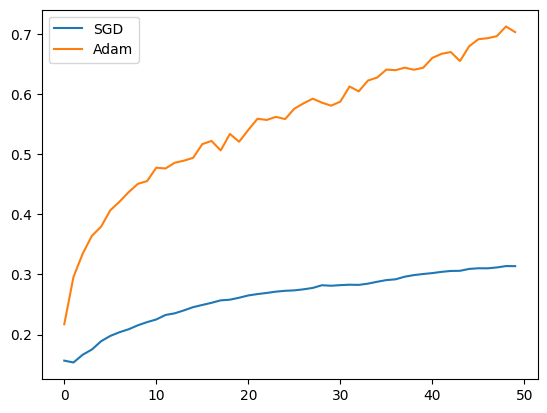

In [ ]:
import numpy as np
#Epoch에 따른 SGD와 Adam optimizer의 trainSet에 대한 model의 정확도를 다음 코드를 사용하여 plot하는 함수
def plot_acc(sgd_accs, adam_accs, label1='SGD', label2='Adam'):
  x = np.arange(len(sgd_accs))

  plt.plot(x, sgd_accs, label=label1)
  plt.plot(x, adam_accs, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(sgd_trainloader_acc, adam_trainloader_acc)

위의 plot를 보면 sgd 보다 adam optimizer가 epoch에 따른 모델 정확도가 더 좋은 걸 볼 수 있다.

## Leaky ReLU와 Sigmoid 성능 비교

### Activation 함수가 nn.Sigmoid인 class 생성

In [ ]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


### nn.Sigmoid로 변경한 모델 (class)로 학습

바뀐 모델로 모델 생성

In [ ]:
model = Model(3 * 32 * 32, 1024)

Adam optimizer 적용

In [ ]:
lr = 0.001
model = model.to('cuda')
optimizer = Adam(model.parameters(), lr=lr)

기존의 코드를 응용하여 학습하는 코드입니다.

In [ ]:
#기존에 학습 코드를 응용해서 adam을 사용한 model의 trainloader를 정확도를 저장하는 코드 추가
criterion = nn.CrossEntropyLoss()
adam_sigmoid_trainloader_acc = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data

    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  adam_sigmoid_trainloader_acc.append(accuracy(model, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 411.41218161582947
Epoch   1 | Loss: 394.50235307216644
Epoch   2 | Loss: 387.6060059070587
Epoch   3 | Loss: 383.8191468715668
Epoch   4 | Loss: 381.04501807689667
Epoch   5 | Loss: 379.2715208530426
Epoch   6 | Loss: 377.00940692424774
Epoch   7 | Loss: 375.7851345539093
Epoch   8 | Loss: 374.0293517112732
Epoch   9 | Loss: 371.80869567394257
Epoch  10 | Loss: 371.36584770679474
Epoch  11 | Loss: 370.30115020275116
Epoch  12 | Loss: 369.39571464061737
Epoch  13 | Loss: 368.32121562957764
Epoch  14 | Loss: 368.0929162502289
Epoch  15 | Loss: 366.6183830499649
Epoch  16 | Loss: 366.32941150665283
Epoch  17 | Loss: 365.1817364692688
Epoch  18 | Loss: 364.4475910663605
Epoch  19 | Loss: 363.5531495809555
Epoch  20 | Loss: 363.333202958107
Epoch  21 | Loss: 362.5406025648117
Epoch  22 | Loss: 362.0526833534241
Epoch  23 | Loss: 361.33634901046753
Epoch  24 | Loss: 361.2069319486618
Epoch  25 | Loss: 360.13078451156616
Epoch  26 | Loss: 359.6030111312866
Epoch  27 | Loss:

### Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델의 epoch에 따른 train 정확도 비교

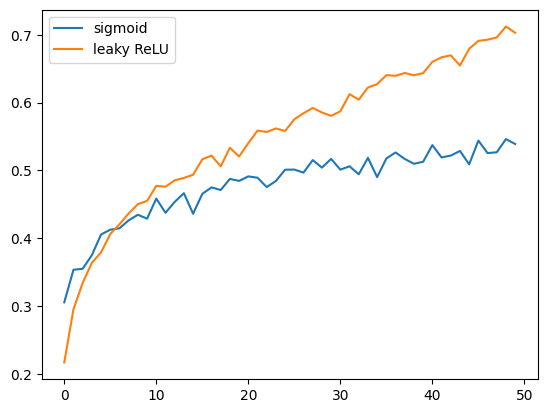

In [ ]:
import numpy as np
#Epoch에 따른 SGD와 Adam optimizer의 trainSet에 대한 model의 정확도를 다음 코드를 사용하여 plot하는 함수
def plot_acc(adam_sigmoid, adam_accs, label1='sigmoid', label2='leaky ReLU'):
  x = np.arange(len(adam_sigmoid))

  plt.plot(x, adam_sigmoid, label=label1)
  plt.plot(x, adam_accs, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(adam_sigmoid_trainloader_acc, adam_trainloader_acc)

activation function을 sigmoid보다 leaky ReLU가 더 좋은 성능을 보이고 있다.

## Dropout을 적용한 이후의 generalization error 확인

### leaky ReLU를 사용하는 MLP의 모든 layer에 dropout 적용한 class 생성
( Dropout 확률은 0.1 )

In [ ]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)
    self.dropout = nn.Dropout(0.1)  #dropout 적용을 위한 생성
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    x = self.dropout(self.act(self.layer3(x)))

    return x


학습전 바꾼 모델로 생성 및 기존 Adam optimizer 사용

In [ ]:
model = Model(3 * 32 * 32, 1024) # 모델 생성

lr = 0.001
model = model.to('cuda')
optimizer = Adam(model.parameters(), lr=lr)

### 정확도 계산하는 코드 변경

In [ ]:
#dataloader에 대한 model의 정확도를 측정하는 코드
def accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()

    cnt = 0
    acc = 0

    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

    return acc / cnt

### 학습 코드 생성
( model.train() 코드 추가 )

In [ ]:
#기존에 학습 코드를 응용해서 model의 trainloader와 testloader의 정확도를 저장하는 코드 추가
criterion = nn.CrossEntropyLoss()
trainloader_acc = []
testloader_acc = []


for epoch in range(n_epochs):
  total_loss = 0.
  model.train() #model.train() 코드 추가
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data

    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  trainloader_acc.append(accuracy(model, trainloader))
  testloader_acc.append(accuracy(model, testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 440.8133294582367
Epoch   1 | Loss: 416.3627018928528
Epoch   2 | Loss: 410.5926995277405
Epoch   3 | Loss: 400.4940024614334
Epoch   4 | Loss: 390.4269918203354
Epoch   5 | Loss: 383.79779875278473
Epoch   6 | Loss: 380.0767284631729
Epoch   7 | Loss: 375.87277233600616
Epoch   8 | Loss: 373.4476888179779
Epoch   9 | Loss: 369.64390444755554
Epoch  10 | Loss: 366.1148135662079
Epoch  11 | Loss: 363.0757452249527
Epoch  12 | Loss: 362.65052831172943
Epoch  13 | Loss: 359.7587203979492
Epoch  14 | Loss: 355.05201506614685
Epoch  15 | Loss: 354.9527790546417
Epoch  16 | Loss: 352.2606203556061
Epoch  17 | Loss: 349.6910871267319
Epoch  18 | Loss: 349.69375455379486
Epoch  19 | Loss: 347.5736446380615
Epoch  20 | Loss: 344.7159938812256
Epoch  21 | Loss: 342.0428570508957
Epoch  22 | Loss: 341.8069657087326
Epoch  23 | Loss: 339.38850951194763
Epoch  24 | Loss: 337.6765583753586
Epoch  25 | Loss: 337.17439925670624
Epoch  26 | Loss: 335.875253200531
Epoch  27 | Loss: 333

## Adam optimizer의 dropout을 적용한 모델의 epoch에 따른 train과 test 정확도 비교 plot

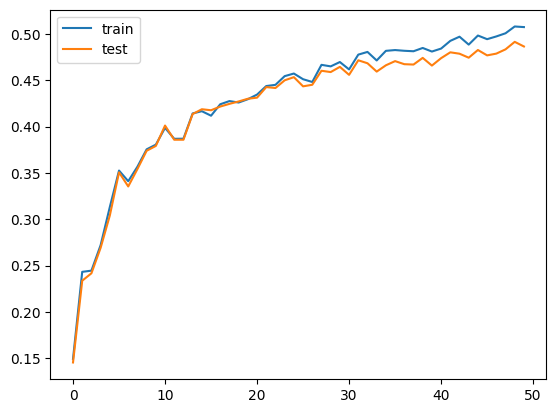

In [ ]:
import numpy as np
#Epoch에 따른 SGD와 Adam optimizer의 trainSet에 대한 model의 정확도를 다음 코드를 사용하여 plot하는 함수
def plot_acc(trainloader_acc, testloader_acc, label1='train', label2='test'):
  x = np.arange(len(trainloader_acc))

  plt.plot(x, trainloader_acc, label=label1)
  plt.plot(x, testloader_acc, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(trainloader_acc, testloader_acc)

Dropout을 적용으로 인해서 train데이터셋과 test데이터셋의 정확도가 비슷한 일반화가 잘되는 것으로 보인다